In [1]:
from pymongo import MongoClient
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import random
import re
from tabulate import tabulate
import age_gender_predictor
from sklearn.feature_extraction.text import TfidfVectorizer
from sklearn.cross_validation import StratifiedShuffleSplit
from sklearn.metrics import precision_recall_curve
from sklearn.metrics import average_precision_score
import age_gender_predictor
import json
%matplotlib inline
from pylab import rcParams
from random import randint
from sklearn.ensemble import RandomForestClassifier
from scipy.sparse import vstack
rcParams['figure.figsize'] = 10, 7

In [2]:
# Data Fetching, transformation and filtering


def getLangRatio(cursor):
    lang_ratios = {}
    for tweet in cursor:
        lang = 1 if tweet["lang"] == "en" else 0
        user_id = tweet["user"]["id"]
        if user_id in lang_ratios:
            lang_ratios[user_id].append(lang)
        else:
            lang_ratios[user_id] = [lang]
    for user_id, ratio in lang_ratios.items():
        lang_ratios[user_id] = np.sum(ratio) / len(ratio)
    return lang_ratios
                                   

def getUsersTweets(dbName,collectionName, en_threshold=0.9):
    cursor = MongoClient("localhost", 27017)[dbName][collectionName].find()
    lang_ratios = getLangRatio(cursor)

    cursor = MongoClient("localhost", 27017)[dbName][collectionName].find()
    usersTweets = {}
    for tweet in cursor:
        userID = tweet["user"]["id"]
        if lang_ratios[userID] < en_threshold:
            continue
        #Processing emotions from Carlos' API
        emotion =  tweet["emotion"]["groups"][0]["name"]
        if len(tweet["emotion"]["groups"]) > 1:
            emotion_2 = tweet["emotion"]["groups"][1]["name"]
            
        ambiguous = True if tweet['emotion']['ambiguous'] == 'yes' else False
       
        if len(tweet["emotion"]["groups"]) > 1:
            emotion_2 = tweet["emotion"]["groups"][1]["name"]    
        else:
            emotion_2 = None
        if tweet["polarity"] == "positive":
            polarity = 1
        elif tweet["polarity"] == "negative":
            polarity = -1
        else:
            polarity = 0
   
            
        date = tweet["created_at"]
        text = tweet['text']

        if userID not in usersTweets:
            usersTweets[userID] = {}
        if date not in usersTweets[userID]:
            usersTweets[userID][date] = {}
            
        usersTweets[userID][date]['text'] = text
        usersTweets[userID][date]['polarity'] =  polarity
        usersTweets[userID][date]['emotion'] =  emotion
        usersTweets[userID][date]['emotion_2'] =  emotion_2
        usersTweets[userID][date]['ambiguous'] =  ambiguous
    return usersTweets



def timeSeriesTransform(usersEmotions):
    for userID in usersEmotions:
        usersEmotions[userID] = pd.DataFrame.from_dict(usersEmotions[userID], orient='index').fillna(0)
        usersEmotions[userID]['dt'] = np.zeros(usersEmotions[userID].shape[0],dtype=float)
        usersEmotions[userID].loc[:-1,'dt'] = (usersEmotions[userID].index[1:].values - usersEmotions[userID].index[:-1].values).astype('timedelta64[s]') / np.timedelta64(60, 's')
    return list(usersEmotions.values())


def getHTTPRows(timeSeries):
    count = 0
    patterns = ['http://','https://']
    conditions = timeSeries['text'].str.contains(patterns[0])
    for pattern in patterns[1:]:
        conditions = conditions | timeSeries['text'].str.contains(pattern)

    return conditions.values

def userFilter(group, spam_threshold=0.5,tweets_threshold=100):    #Spam and inactive user filter
    new_group = []
    for timeSeries in group:
        http_rows = getHTTPRows(timeSeries)
        average_http_count = np.sum(http_rows) / timeSeries.shape[0]
        if (average_http_count < spam_threshold) and (timeSeries.shape[0] > tweets_threshold):
            new_group.append(timeSeries)
    return new_group




In [51]:
class Group(object):
    
    
    
    def __init__(self, name, group=None, spam_threshold=0.5, tweets_threshold=100, **kwargs):
        self.name = name

        dbName  = kwargs.get("dbName", None)
        collectionName  = kwargs.get("collectionName", None)
        
        if dbName is None or collectionName is None:
            self.group = group
        else:

            self.group = userFilter(timeSeriesTransform(getUsersTweets(dbName,collectionName)), spam_threshold=spam_threshold, tweets_threshold=tweets_threshold)
        
 
        
    def getTexts(self):
        return ["\n".join(timeSeries["text"].values) for timeSeries in self.group]
    def getName(self):
        return self.name
    def getSize(self):
        return len(self.group)
    def __repr__(self):
        return repr(self.group)
    def __add__(self, other):
        return Group(self.name, self.group + other.group)
    
    
    def __iadd__(self, other):
        self.group += other.group
        return self    
    






BPD_group_clean = Group("BPD",dbName = "patients",collectionName="BPD_clean")
regular_group = Group("Random Samples",dbName = "idea",collectionName="regularUser_en_fixed_emotion")
bipolar_group_clean = Group("Bipolar",dbName ="patients", collectionName="bipolar_clean")
mix_group = Group("Mix", dbName = "patients",collectionName="bb_mix")


BPD_all = BPD_group_clean + mix_group
bipolar_all = bipolar_group_clean + mix_group


493 Normal and 284 Bipolar in Training Data
55 Normal and 32 Bipolar in Test Data

493 Normal and 217 BPD in Training Data
55 Normal and 24 BPD in Test Data



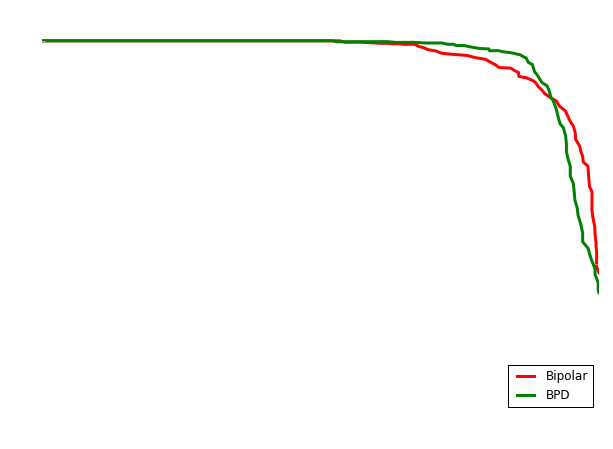

['mental health', 'bipolar disorder', 'manic', 'illness', 'mental illness', 'health', 'bpd', 'diagnosed', 'medication', 'bipolarblogger', 'mentalillness', 'disorder', 'new meds', 'issues', 'suffer', 'hugs', 'mind', 'stable', 'anxious', 'understanding', 'treatment', 'thanks follow', 'bipolar', 'supportive', 'bipolarus', 'helps', 'psychosis', 'depression', 'games', 'holidays', 'blogs', 'game', 'blog http', 'ok', 'lamictal', 'hospital', 'football', 'unwell', 'doc', 'hope ok', 'angry', 'need support', 'husband', 'know bipolar', 'hard time', 'nhs', 'abilify', 'nah', 'mentalhealth https', 'diagnosed bipolar']
['bpd', 'illness', 'personality disorder', 'mental', 'anxiety', 'triggering', 'pain', 'people bpd', 'anxious', 'mental illness', 'issues', 'bpdchat', 'evening', 'thoughts', 'selfharm', 'officialbpdchat', 'depression', 'trigger', 'hope ok', 'mentalhealth http', 'bpd bipolar', 'meds', 'agitated', 'unwell', 'suicidal', 'mental health', 'helps', 'hospital', 'bpd http', 'emotionally', 'crisi

In [4]:
#Tf-iDF performance, really robust



def XYGenerator(labeled_data):
    X, Y = labeled_data[0]
    

    
    for x, y in labeled_data[1:]:
        try:
            
            X = np.concatenate((X, x))
        except:
            X = vstack([X, x])
            
        Y = np.concatenate((Y, y))
    
   
    
    
    return X, Y


class TextFeatureGroups(object):
    
    def __init__(self, base, groups, model = "Tf-iDF"):
        self.base = base
        self.groups = groups
        self.name_to_index = {group.getName(): index for index, group in enumerate(groups)}
       
        base_texts = base.getTexts()
        self.text_models = []
        self.classifiers = []
        for group in groups:
            group_texts = group.getTexts()
            total_texts = base_texts  + group_texts
            if model == "Tf-iDF":
                text_model = TfidfVectorizer(stop_words="english",ngram_range = (1,2))
            text_model.fit(total_texts)    
            X = text_model.transform(total_texts)  
            Y = np.array([0] * base.getSize() + [1]*group.getSize(), dtype=int)
            classifier  = RandomForestClassifier(n_jobs=-1, max_features="sqrt", n_estimators=128)
            classifier.fit(X,Y)
            self.classifiers.append(classifier)
            self.text_models.append(text_model)
    
    
    def getTopFeatures(self, name, k=50):
        index = self.name_to_index[name]
        text_model = self.text_models[index]
        classifier = self.classifiers[index]
        feature_indicies = np.argsort(classifier.feature_importances_)
        vector2word = text_model.get_feature_names()
        top_words = []
        for i in range(k):
            vector = feature_indicies[-i-1]
            word = vector2word[vector]
            top_words.append(word)
        return top_words
            
            
        
        

    
    
    

    def getGroup(self,name):
        index = self.name_to_index[name]
        return self.group[index]
            
    def classify(self,name, group):
        index = self.name_to_index[name]
        classifier = self.classifiers[index]
        text_model = self.text_models[index]
        X = text_model.transform(group.getTexts())
        return classifier.predict(X) 
        
    
            
    def renderPrecisionRecall(self,colors=['r','g','b',"y","w"], n_fold = 30):
        classifier  = RandomForestClassifier(n_jobs=-1, max_features="sqrt", n_estimators=128)
        fig, ax = plt.subplots()
        ax.spines['bottom'].set_color('white')
        ax.spines['top'].set_color('white') 
        ax.spines['right'].set_color('white')
        ax.spines['left'].set_color('white')
        ax.tick_params(axis='x', colors='white')
        ax.tick_params(axis='y', colors='white')
        ax.title.set_color('white')
        ax.yaxis.label.set_color('white')
        ax.xaxis.label.set_color('white')
        plt.xlim([0.0, 1.0])
        plt.ylim([0.0, 1.05])
        plt.xlabel('Recall')
        plt.ylabel('Precision')
        plt.title('Precision Recall Curve')

        for g, group in enumerate(self.groups):

            SCORES = np.array([])
            LABELS = np.array([])
            
            
            X = self.text_models[g].transform(self.base.getTexts()+group.getTexts())
            Y =  np.zeros(self.base.getSize() + group.getSize(), dtype=int)
            Y[self.base.getSize():] = 1
            
            sss = StratifiedShuffleSplit(Y, n_fold, random_state=randint(0,65536) )


            for train_index, test_index in sss:

                X_train, X_test = X[train_index], X[test_index]
                Y_train, Y_test = Y[train_index], Y[test_index]

                classifier.fit(X_train, Y_train)
                score = classifier.predict_proba(X_test)[:,1]
                SCORES = np.concatenate((SCORES, score))
                LABELS = np.concatenate((LABELS, Y_test))


            precision, recall, _ = precision_recall_curve(LABELS, SCORES, pos_label=1)
            average_precision = average_precision_score(LABELS, SCORES)






            positive_train = np.count_nonzero(Y_train)
            positive_test = np.count_nonzero(Y_test)
            normal_train = Y_train.shape[0] - positive_train
            normal_test = Y_test.shape[0] - positive_test


            print("{} Normal and {} {} in Training Data".format(normal_train,positive_train,group.getName()))
            print("{} Normal and {} {} in Test Data\n".format(normal_test,positive_test,group.getName()))
            plt.plot(recall, precision, label=group.getName() , color=colors[g],linewidth=3)

        plt.legend(loc="lower right")
        plt.show()

            
        
        
            
        

            
tfidf_groups = TextFeatureGroups(regular_group, [bipolar_all,BPD_all])
tfidf_groups.renderPrecisionRecall()
bipolar_words = tfidf_groups.getTopFeatures("Bipolar")
BPD_words = tfidf_groups.getTopFeatures("BPD")

print(bipolar_words)
print(BPD_words)



In [52]:
#Expert experiemnt of Tf-iDF kinda sucks
bipolar_experts =  Group("bipolar Expert", dbName= "patients", collectionName="bipolar_experts", spam_threshold=0.55)
BPD_experts =  Group("BPD Expert", dbName="idea", collectionName="coach_tweets_emotion", spam_threshold=0.55)



bipolar_result = tfidf_groups.classify("Bipolar", bipolar_experts)
BPD_result = tfidf_groups.classify("BPD", BPD_experts )






print("===== The Tf-iDF false positive experiment on disorder experts =====\n")

misclassified = np.sum(bipolar_result)
size = bipolar_experts.getSize()
name = bipolar_experts.getName()

print("{} out of {} {} experts are mis-calssified as patients. Accuracy {}".format(np.sum(bipolar_result), size, name, (size-misclassified)/size))
misclassified = np.sum(BPD_result)
size = BPD_experts.getSize()
name = BPD_experts.getName()
print("{} out of {} {} experts are mis-calssified as patients. Accuracy {}".format(np.sum(BPD_result), size, name, (size-misclassified)/size))





===== The Tf-iDF false positive experiment on disorder experts =====

7 out of 9 bipolar Expert experts are mis-calssified as patients. Accuracy 0.2222222222222222
9 out of 11 BPD Expert experts are mis-calssified as patients. Accuracy 0.18181818181818182


In [26]:
bipolar_experts.getSize()

6

493 Normal and 250 Bipolar in Training Data
55 Normal and 28 Bipolar in Test Data

493 Normal and 182 BPD in Training Data
55 Normal and 21 BPD in Test Data



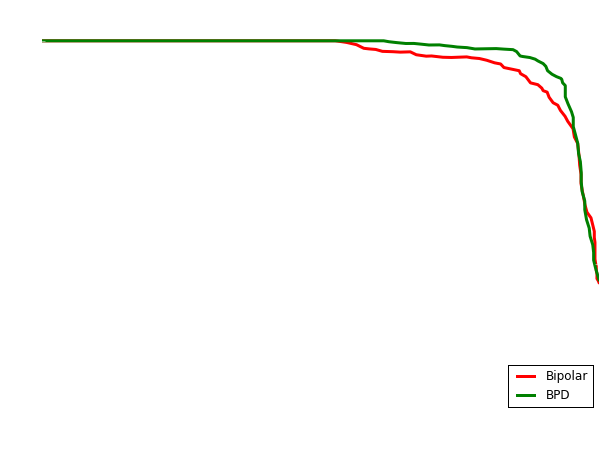

===== The cross-valadation experiment on disorder experts =====

137 out of 203 BPD  are mis-calssified as Bipolar Accuracy 0.3251231527093596
147 out of 278 Bipolar  are mis-calssified as BPD Accuracy 0.4712230215827338


In [10]:
#Cross classification of Tf-iDF
tfidf_groups_clean = TextFeatureGroups(regular_group, [bipolar_group_clean,BPD_group_clean])
tfidf_groups_clean.renderPrecisionRecall()

bipolar_result = tfidf_groups_clean.classify("Bipolar", BPD_group_clean)
BPD_result = tfidf_groups_clean.classify("BPD", bipolar_group_clean)

#print(bipolar_result)
#print(BPD_result)




print("===== The cross-valadation experiment on disorder experts =====\n")

misclassified = np.sum(bipolar_result)
size = BPD_group_clean.getSize()
name = BPD_group_clean.getName()
        
print("{} out of {} {}  are mis-calssified as {} Accuracy {}".format(np.sum(bipolar_result), size, name,"Bipolar",(size-misclassified)/size))
misclassified = np.sum(BPD_result)
size = bipolar_group_clean.getSize()
name = bipolar_group_clean.getName()
print("{} out of {} {}  are mis-calssified as {} Accuracy {}".format(np.sum(BPD_result), size, name,"BPD", (size-misclassified)/size))







493 Normal and 284 Bipolar in Training Data
55 Normal and 32 Bipolar in Test Data



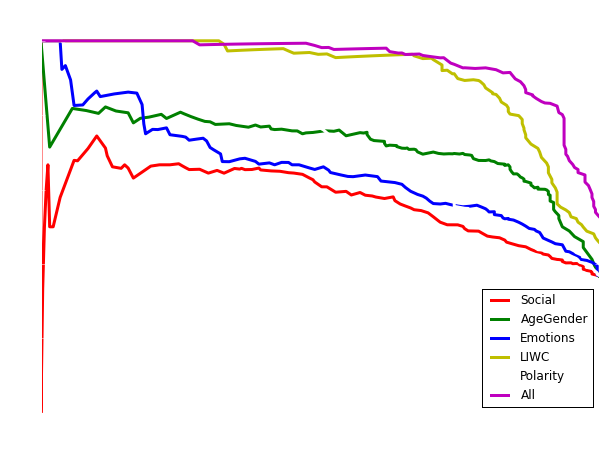

493 Normal and 217 BPD in Training Data
55 Normal and 24 BPD in Test Data



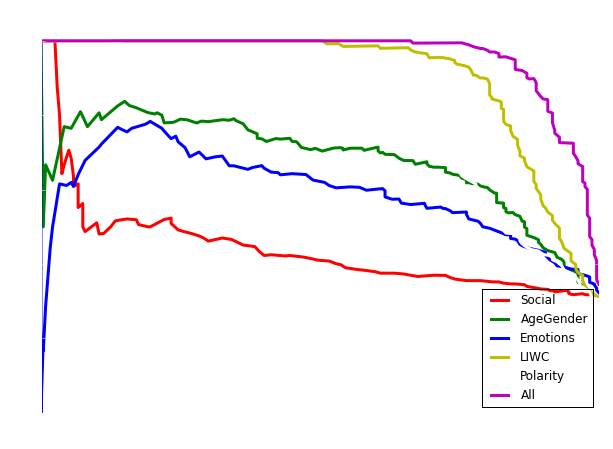

In [53]:
#Individual pattern of life feature performance






class POLFeaturerGroups(object):
    
    @staticmethod
    def transform(self, ):
        features_dict = getAllFeature(group)
        
    
    def __init__(self, base, groups):
        feature2categories = getCategories(base)
        self.categories = set(feature2categories.values())
        self.name_to_index = {group.getName(): index for index, group in enumerate(groups)}
        self.base_name = base.getName()
        self.features = []
        self.index2feature = []
        base_feature_dict = getAllFeature(base)
        self.base_feature = np.zeros((base.getSize(),len(base_feature_dict)), dtype = float)
        for name, values in base_feature_dict.items():
            cursor = len(self.index2feature)
          
            self.base_feature[:,cursor] = values
            category = feature2categories[name]
            self.index2feature.append((name, category))
        

        for group in groups:
            features_dict = getAllFeature(group)
            feature = np.zeros((group.getSize(),len(self.index2feature)),dtype=float)
            for cursor, (name,category) in enumerate(self.index2feature):
                value = features_dict[name]
                feature[:,cursor] = value
            self.features.append(feature)
            
    def getLabeledData(self,name, selection = "all"):
        if selection is "all":
            selection = range(len(self.index2feature))
        
        base_feature = self.base_feature[:,selection]
        base_length = base_feature.shape[0]
        index = self.name_to_index[name]
        feature = self.features[index][:,selection]

        X = np.zeros((base_length  + feature.shape[0],len(selection)),dtype=float)
        X[0:base_length ,:] = base_feature
        X[base_length:,:] = feature
        Y = np.array([0]*base_length  + [1]*feature.shape[0])
        
        return X, Y
        
    
    def getFeatureImportance_all(self,name):
        X, Y = self.getLabeledData(name)
        classifier = RandomForestClassifier(n_jobs=-1, max_features="sqrt", n_estimators=128)
        classifier.fit(X,Y)
        features_indicies = np.argsort(classifier.feature_importances_)
        feature_names = [self.index2feature[i] for i in features_indicies ]
        return feature_names[::-1]
    
    def getFeature(self, name, selection="all"):
        if selection is "all":
            selection = list(range(len(self.index2feature)))
        index = self.name_to_index[name]
        feature =  self.features[index]
        return feature[:, selection]
        
    
    
    def classify(self,name, target_name, selection="all"):
        X, Y = self.getLabeledData(name, selection)
        classifier = RandomForestClassifier(n_jobs=-1, max_features="sqrt", n_estimators=128)
        classifier.fit(X,Y)
        test_x = self.getFeature(target_name,selection)
        return classifier.predict(test_x)
    
    def renderPrecisionRecall_all(self, name,colors=['r','g','b',"y","w", "m"], n_fold = 30):
        classifier  = RandomForestClassifier(n_jobs=-1, max_features="sqrt", n_estimators=128)
        fig, ax = plt.subplots()
        ax.spines['bottom'].set_color('white')
        ax.spines['top'].set_color('white') 
        ax.spines['right'].set_color('white')
        ax.spines['left'].set_color('white')
        ax.tick_params(axis='x', colors='white')
        ax.tick_params(axis='y', colors='white')
        ax.title.set_color('white')
        ax.yaxis.label.set_color('white')
        ax.xaxis.label.set_color('white')
        plt.xlim([0.0, 1.0])
        plt.ylim([0.0, 1.05])
        plt.xlabel('Recall')
        plt.ylabel('Precision')
        plt.title('Precision Recall Curve: {}'.format(name))
        
        
        categories = list(self.categories) + ["All"]
        for g,category in enumerate(categories):
            if category == "All":
                selection = range(len(self.index2feature))
            else:
                selection = [i for i, (feature_name, feature_category) in enumerate(self.index2feature) if category == feature_category]
        

            SCORES = np.array([])
            LABELS = np.array([])
            
            
            X, Y = self.getLabeledData(name, selection)
            
            sss = StratifiedShuffleSplit(Y, n_fold, random_state=randint(0,65536) )


            for train_index, test_index in sss:

                X_train, X_test = X[train_index], X[test_index]
                Y_train, Y_test = Y[train_index], Y[test_index]

                classifier.fit(X_train, Y_train)
                score = classifier.predict_proba(X_test)[:,1]
                SCORES = np.concatenate((SCORES, score))
                LABELS = np.concatenate((LABELS, Y_test))


            precision, recall, _ = precision_recall_curve(LABELS, SCORES, pos_label=1)
            average_precision = average_precision_score(LABELS, SCORES)






            positive_train = np.count_nonzero(Y_train)
            positive_test = np.count_nonzero(Y_test)
            normal_train = Y_train.shape[0] - positive_train
            normal_test = Y_test.shape[0] - positive_test


           
            plt.plot(recall, precision, label=category , color=colors[g],linewidth=3)
            
        print("{} Normal and {} {} in Training Data".format(normal_train,positive_train,name))
        print("{} Normal and {} {} in Test Data\n".format(normal_test,positive_test,name))
        plt.legend(loc="lower right")
        plt.show()

    def renderPrecisionRecall_vs(self, name,colors=['r','g','b',"y","w", "m"], n_fold = 30):
        classifier  = RandomForestClassifier(n_jobs=-1, max_features="sqrt", n_estimators=128)
        fig, ax = plt.subplots()
        ax.spines['bottom'].set_color('white')
        ax.spines['top'].set_color('white') 
        ax.spines['right'].set_color('white')
        ax.spines['left'].set_color('white')
        ax.tick_params(axis='x', colors='white')
        ax.tick_params(axis='y', colors='white')
        ax.title.set_color('white')
        ax.yaxis.label.set_color('white')
        ax.xaxis.label.set_color('white')
        plt.xlim([0.0, 1.0])
        plt.ylim([0.0, 1.05])
        plt.xlabel('Recall')
        plt.ylabel('Precision')
        plt.title('Precision Recall Curve: {}'.format(name))
        
        
        categories = [["AgeGender","Social","Polarity","Emotions"],["LIWC"]]
        for g,category in enumerate(categories):
            if category == "All":
                selection = range(len(self.index2feature))
            else:
                selection = [i for i, (feature_name, feature_category) in enumerate(self.index2feature) if category in feature_category]
        

            SCORES = np.array([])
            LABELS = np.array([])
            
            
            X, Y = self.getLabeledData(name, selection)
            
            sss = StratifiedShuffleSplit(Y, n_fold, random_state=randint(0,65536) )


            for train_index, test_index in sss:

                X_train, X_test = X[train_index], X[test_index]
                Y_train, Y_test = Y[train_index], Y[test_index]

                classifier.fit(X_train, Y_train)
                score = classifier.predict_proba(X_test)[:,1]
                SCORES = np.concatenate((SCORES, score))
                LABELS = np.concatenate((LABELS, Y_test))


            precision, recall, _ = precision_recall_curve(LABELS, SCORES, pos_label=1)
            average_precision = average_precision_score(LABELS, SCORES)






            positive_train = np.count_nonzero(Y_train)
            positive_test = np.count_nonzero(Y_test)
            normal_train = Y_train.shape[0] - positive_train
            normal_test = Y_test.shape[0] - positive_test


           
            plt.plot(recall, precision, label=category , color=colors[g],linewidth=3)
            
        print("{} Normal and {} {} in Training Data".format(normal_train,positive_train,name))
        print("{} Normal and {} {} in Test Data\n".format(normal_test,positive_test,name))
        plt.legend(loc="lower right")
        plt.show()
    def GA_evaluate(self,name, target_name, gene, selection_all, classifier):
          

        selection = selection_all[gene]
        if selection.shape[0] <= 5:
            return -100, selection
        X,Y = self.getLabeledData(name, selection)
        sss = list(StratifiedShuffleSplit(Y, 1, random_state=randint(0,65536) ))
        train_index, test_index = sss[0]
        X_train, X_test = X[train_index], X[test_index]
        Y_train, Y_test = Y[train_index], Y[test_index]
        classifier.fit(X_train, Y_train)
        score = classifier.score(X_test, Y_test)
        classifier.fit(X, Y)

        
        
        
        target_X = self.getFeature(target_name, selection)
        
        score  -= np.sum(classifier.predict_proba(target_X)[:,1])

        return score, selection


      
    def GA_crossover_mutate(self, genes, scores):
        
         
        gene_length = genes.shape[1]
        population = genes.shape[0]
        new_genes = np.zeros((population, gene_length),dtype=bool)
        
        for i in range(population):
            choice = np.random.choice(population, population/10, replace=False)
            compete_rank = np.argsort(scores[choice])
            top = genes[compete_rank[-1],:]
            second = genes[compete_rank[-2],:]

            #crossover
            selected_chromosoe = np.random.choice(gene_length, population/10, replace=False)
            kid_a = top
            kid_a[selected_chromosoe] = second
            #mutate
            if randint(0,100) == 0:
                random_index = randint(0, gene_length-1)
                kid_a[random_index] = -kid_a[random_index]
            
            new_genes[i,:] = kid_a
        
        
        
        return new_genes
    
    def GA_evolve(self,name, target_name, genes, classifier, selection_all):
        best_score = -100
        population = genes.shape[0]
        scores = np.zeros(population,dtype=int)
        for i in range(population):
            gene = genes[i,:]
            score, selection = self.GA_evaluate(name, target_name,gene, selection_all, classifier)
            
            scores[i] = score
        if score > best_score:
            best_score = score
            best_selection = selection
            
        genes = self.GA_crossover_mutate(genes, scores)
            
            
            
        return genes, best_score, best_selection


    

            
        
        
    def GA_optmize(self, name, target_name, population=100,generations=100):

        best_selection = range(len(self.index2feature))
        best_score = -100

        tf = np.array([True,False], dtype=bool)
        genes = np.random.choice(tf, (population,len(self.index2feature))) #init
        classifier = RandomForestClassifier(n_jobs=-1, max_features="sqrt", n_estimators=4)
        selection_all = np.array(best_selection,dtype=int)


        gene2selection = lambda gene: list(selection_all[gene])
        for i in range(generations):
            genes, score, selection = self.GA_evolve(name, target_name, genes, classifier,selection_all)
            if score > best_score:
                best_score = score
                best_selection = selection
                print(best_score)
                print(best_selection)
    





        return best_score, best_selection
        
        
        
        
        
    
      
pol_groups = POLFeaturerGroups(regular_group, [bipolar_all,BPD_all, bipolar_experts,BPD_experts])


pol_groups.renderPrecisionRecall_all("Bipolar",n_fold=10)
pol_groups.renderPrecisionRecall_all("BPD",n_fold=10)


In [ ]:
pol_groups_1 = POLFeaturerGroups(regular_group, [bipolar_all,BPD_all, bipolar_experts,BPD_experts])

pol_groups_1.renderPrecisionRecall_vs

In [ ]:
best_bipolar_selection = pol_groups.GA_optmize("Bipolar", "bipolar Expert",generations=300 )
best_BPD_selection = pol_groups.GA_optmize("BPD", "BPD Expert",generations=300)

In [21]:
pol_groups.name_to_index

{'BPD': 1, 'BPD Expert': 3, 'Bipolar': 0, 'bipolar Expert': 2}

In [22]:
index2feature = pol_groups.index2feature
for i, (feature_name, category) in enumerate(index2feature):
    print(i, feature_name)

0 LIWC_leisure
1 trust
2 LIWC_achieve
3 fear
4 LIWC_filler
5 LIWC_negate
6 LIWC_adverb
7 LIWC_home
8 LIWC_quant
9 LIWC_posemo
10 LIWC_anger
11 LIWC_anx
12 LIWC_pronoun
13 LIWC_relativ
14 LIWC_humans
15 LIWC_tentat
16 LIWC_certain
17 LIWC_conj
18 anticipation
19 LIWC_future
20 LIWC_family
21 LIWC_work
22 LIWC_we
23 LIWC_article
24 LIWC_preps
25 LIWC_insight
26 mention_rate
27 joy
28 negative_combos
29 LIWC_money
30 LIWC_they
31 LIWC_friend
32 LIWC_health
33 LIWC_percept
34 LIWC_past
35 frequent_mentions
36 LIWC_verb
37 LIWC_ppron
38 LIWC_nonfl
39 LIWC_cause
40 LIWC_negemo
41 LIWC_sad
42 anger
43 LIWC_shehe
44 LIWC_sexual
45 tweets_rate
46 LIWC_auxverb
47 LIWC_time
48 positive_combos
49 LIWC_incl
50 LIWC_motion
51 LIWC_i
52 age
53 LIWC_funct
54 LIWC_feel
55 LIWC_ingest
56 LIWC_relig
57 LIWC_social
58 disgust
59 LIWC_death
60 LIWC_space
61 LIWC_affect
62 LIWC_inhib
63 LIWC_ipron
64 gender
65 unique_mentions
66 positive_ratio
67 surprise
68 flips
69 LIWC_hear
70 negative_ratio
71 LIWC_bio


In [58]:


selection = []

removed_features = []
for i in range(len(index2feature)):
    name,category =  index2feature[i]
    if any(category == x for x in[]):
        removed_features.append(name)
    elif any(name == x for x in ["LIWC_health"]):
        removed_features.append(name)

    else:                   
        selection.append(i)
print(removed_features)


bipolar_wrong_all = []
BPD_wrong_all = []
bipolar_wrong_selected = []
BPD_wrong_selected = []
n_fold = 100

for i in range(n_fold):

    bipolar_prediction_all = pol_groups.classify("Bipolar", "bipolar Expert")
    bipolar_wrong_all.append( np.sum(bipolar_prediction_all))
    
    BPD_prediction_all =  pol_groups.classify("BPD", "BPD Expert")
    BPD_wrong_all.append( np.sum(BPD_prediction_all))


    bipolar_prediction_selected = pol_groups.classify("Bipolar", "bipolar Expert", selection)
    bipolar_wrong_selected.append( np.sum(bipolar_prediction_selected))
    
    BPD_prediction_selected =  pol_groups.classify("BPD", "BPD Expert", selection)
    BPD_wrong_selected.append( np.sum(BPD_prediction_selected))

    
    
bipolar_expert_size = bipolar_prediction_all.shape[0]
BPD_expert_size = BPD_prediction_all.shape[0]

    
bipolar_result_all = "{0:2f}/{1}".format(np.mean(bipolar_wrong_all), bipolar_expert_size)
BPD_result_all = "{0:2f}/{1}".format(np.mean(BPD_wrong_all), BPD_expert_size)
bipolar_result_selected = "{0:2f}/{1}".format(np.mean(bipolar_wrong_selected), bipolar_expert_size)
BPD_result_selected = "{0:2f}/{1}".format(np.mean(BPD_wrong_selected), BPD_expert_size)
print("\n=======================\n")
headers = ["Condition", "Bipolar", "BPD"]
contents = [["Before",bipolar_result_all, BPD_result_all],["After", bipolar_result_selected, BPD_result_selected]]
#print(bipolar_result_all, BPD_result_all)
#print(bipolar_result_selected, BPD_result_selected)
print(tabulate(contents, headers=headers))


['LIWC_health']


Condition    Bipolar     BPD
-----------  ----------  -----------
Before       6.720000/9  4.860000/11
After        3.370000/9  2.820000/11


In [ ]:

['LIWC_leisure', 'LIWC_achieve', 'LIWC_filler', 'LIWC_negate', 'LIWC_adverb', 'LIWC_home', 'LIWC_quant', 'LIWC_posemo', 'LIWC_anger', 'LIWC_anx', 'LIWC_pronoun', 'LIWC_relativ', 'LIWC_humans', 'LIWC_tentat', 'LIWC_certain', 'LIWC_conj', 'LIWC_future', 'LIWC_family', 'LIWC_work', 'LIWC_we', 'LIWC_article', 'LIWC_preps', 'LIWC_insight', 'LIWC_money', 'LIWC_they', 'LIWC_friend', 'LIWC_health', 'LIWC_percept', 'LIWC_past', 'LIWC_verb', 'LIWC_ppron', 'LIWC_nonfl', 'LIWC_cause', 'LIWC_negemo', 'LIWC_sad', 'LIWC_shehe', 'LIWC_sexual', 'LIWC_auxverb', 'LIWC_time', 'LIWC_incl', 'LIWC_motion', 'LIWC_i', 'LIWC_funct', 'LIWC_feel', 'LIWC_ingest', 'LIWC_relig', 'LIWC_social', 'LIWC_death', 'LIWC_space', 'LIWC_affect', 'LIWC_inhib', 'LIWC_ipron', 'LIWC_hear', 'LIWC_bio', 'LIWC_swear', 'LIWC_number', 'LIWC_excl', 'LIWC_see', 'LIWC_body', 'LIWC_discrep', 'LIWC_present', 'LIWC_cogmech', 'LIWC_assent', 'LIWC_you']

=======================

Condition    Bipolar     BPD
-----------  ----------  -----------
Before       6.690000/9  4.810000/11
After        2.870000/9  2.120000/11



['mention_rate', 'frequent_mentions', 'tweets_rate', 'unique_mentions']

=======================

Condition    Bipolar     BPD
-----------  ----------  -----------
Before       3.980000/6  4.900000/11
After        3.860000/6  4.560000/11




['negative_combos', 'positive_combos', 'positive_ratio', 'flips', 'negative_ratio']

=======================

Condition    Bipolar     BPD
-----------  ----------  -----------
Before       3.980000/6  4.640000/11
After        3.890000/6  5.590000/11



['trust', 'fear', 'anticipation', 'joy', 'anger', 'disgust', 'surprise', 'sadness']

=======================

Condition    Bipolar     BPD
-----------  ----------  -----------
Before       3.990000/6  4.790000/11
After        4.000000/6  4.530000/11



['LIWC_leisure', 'LIWC_achieve', 'LIWC_filler', 'LIWC_negate', 'LIWC_adverb', 'LIWC_home', 'LIWC_quant', 'LIWC_posemo', 'LIWC_anger', 'LIWC_anx', 'LIWC_pronoun', 'LIWC_relativ', 'LIWC_humans', 'LIWC_tentat', 'LIWC_certain', 'LIWC_conj', 'LIWC_future', 'LIWC_family', 'LIWC_work', 'LIWC_we', 'LIWC_article', 'LIWC_preps', 'LIWC_insight', 'LIWC_money', 'LIWC_they', 'LIWC_friend', 'LIWC_health', 'LIWC_percept', 'LIWC_past', 'LIWC_verb', 'LIWC_ppron', 'LIWC_nonfl', 'LIWC_cause', 'LIWC_negemo', 'LIWC_sad', 'LIWC_shehe', 'LIWC_sexual', 'LIWC_auxverb', 'LIWC_time', 'LIWC_incl', 'LIWC_motion', 'LIWC_i', 'age', 'LIWC_funct', 'LIWC_feel', 'LIWC_ingest', 'LIWC_relig', 'LIWC_social', 'LIWC_death', 'LIWC_space', 'LIWC_affect', 'LIWC_inhib', 'LIWC_ipron', 'gender', 'LIWC_hear', 'LIWC_bio', 'LIWC_swear', 'LIWC_number', 'LIWC_excl', 'LIWC_see', 'LIWC_body', 'LIWC_discrep', 'LIWC_present', 'LIWC_cogmech', 'LIWC_assent', 'LIWC_you']

=======================

Condition    Bipolar     BPD
-----------  ----------  -----------
Before       3.910000/6  4.780000/11
After        2.000000/6  2.000000/11


['LIWC_leisure', 'LIWC_achieve', 'LIWC_filler', 'LIWC_negate', 'LIWC_adverb', 'LIWC_home', 'LIWC_quant', 'LIWC_posemo', 'LIWC_anger', 'LIWC_anx', 'LIWC_pronoun', 'LIWC_relativ', 'LIWC_humans', 'LIWC_tentat', 'LIWC_certain', 'LIWC_conj', 'LIWC_future', 'LIWC_family', 'LIWC_work', 'LIWC_we', 'LIWC_article', 'LIWC_preps', 'LIWC_insight', 'LIWC_money', 'LIWC_they', 'LIWC_friend', 'LIWC_health', 'LIWC_percept', 'LIWC_past', 'LIWC_verb', 'LIWC_ppron', 'LIWC_nonfl', 'LIWC_cause', 'LIWC_negemo', 'LIWC_sad', 'LIWC_shehe', 'LIWC_sexual', 'LIWC_auxverb', 'LIWC_time', 'LIWC_incl', 'LIWC_motion', 'LIWC_i', 'LIWC_funct', 'LIWC_feel', 'LIWC_ingest', 'LIWC_relig', 'LIWC_social', 'LIWC_death', 'LIWC_space', 'LIWC_affect', 'LIWC_inhib', 'LIWC_ipron', 'LIWC_hear', 'LIWC_bio', 'LIWC_swear', 'LIWC_number', 'LIWC_excl', 'LIWC_see', 'LIWC_body', 'LIWC_discrep', 'LIWC_present', 'LIWC_cogmech', 'LIWC_assent', 'LIWC_you']

=======================

Condition    Bipolar     BPD
-----------  ----------  -----------
Before       3.960000/6  4.830000/11
After        2.330000/6  2.100000/11




['LIWC_health']

=======================

Condition    Bipolar     BPD
-----------  ----------  -----------
Before       3.980000/6  4.780000/11
After        1.980000/6  2.710000/11

In [388]:
#Expert experiment to product best combinations of POL

bipolar_result = pol_groups.classify("Bipolar", "bipolar Expert")
BPD_result = pol_groups.classify("BPD", "BPD Expert")



print("===== The POL false positive experiment on disorder experts =====\n")

misclassified = np.sum(bipolar_result)
size = bipolar_experts.getSize()
name = bipolar_experts.getName()

print("{} out of {} {} experts are mis-calssified as patients. Accuracy {}".format(np.sum(bipolar_result), size, name, (size-misclassified)/size))
misclassified = np.sum(BPD_result)
size = BPD_experts.getSize()
name = BPD_experts.getName()
print("{} out of {} {} experts are mis-calssified as patients. Accuracy {}".format(np.sum(BPD_result), size, name, (size-misclassified)/size))



===== The POL false positive experiment on disorder experts =====

8 out of 13 BPD Expert experts are mis-calssified as patients. Accuracy 0.38461538461538464
6 out of 11 bipolar Expert experts are mis-calssified as patients. Accuracy 0.45454545454545453


In [ ]:
#Cross Classification of POL

In [11]:
#Show the LIWC correlations 
def loads_LIWC():
    f = open("../4_prediction_visualization/categories.json", 'r')
    categories = json.load(f)
    f = open("../4_prediction_visualization/words.json", 'r')
    words = json.load(f)
    patterns_categories = {}
    for word, category in words.items():
        if word[-1] == '*':
            current_dict = patterns_categories
            for char in word:
                if char == '*':
                   
                    #current_dict = category
                    pre_dict[word[-2]] = category
                    break
                
                elif char not in current_dict:
                    current_dict[char] = {}
                pre_dict = current_dict
                current_dict = current_dict[char]
                
    return categories, words, patterns_categories
LIWC_categories, LIWC_words, LIWC_patterns_categories = loads_LIWC() 

def getLIWC_user(timeSeries):
 
    LIWC_counts = {}
    
 
    features = np.zeros(len(LIWC_categories),dtype=int)
    
    texts= timeSeries["text"].values
    for text in texts:
        words = text.strip().split()
        for word in words:
            category_indices = LIWC_words.get(word,[])
            if category_indices == []:
                current_dict = LIWC_patterns_categories
                for char in word[:-1]:
                    current_dict = current_dict.get(char,[])
                    if isinstance(current_dict,list):
                        category_indices = current_dict                            
                        break


            for category_index in category_indices:

                category_name = LIWC_categories[category_index]

                LIWC_counts[category_name] = LIWC_counts.get(category_name,0) + 1

    for category_name in LIWC_counts:
        LIWC_counts[category_name] /= timeSeries.shape[0]
    
    return LIWC_counts

def getLIWC_group(group):
    LIWC_counts = {}
    users_num = len(group)
    for category in LIWC_categories.values():
        LIWC_counts[category] = []
    for timeSeries in group:
        user_LIWC_count = getLIWC_user(timeSeries)
      
        for category in LIWC_categories.values():
          
            LIWC_counts[category].append(user_LIWC_count.get(category,0))
            
    
    
    return LIWC_counts

#polarity
def getFlipsCount(timeSeries, upperbound=60, lowerbound = 0):
    flips = getFlips(timeSeries)
    durations = getFlipsDuration(timeSeries, flips)
    return np.sum((durations > lowerbound) & (durations < upperbound) )



def getFlips(timeSeries, attribute= 'polarity'):
    flips = np.zeros(timeSeries.shape[0],dtype=bool)
    polarity = timeSeries[attribute].values[:-1]
    right_elements = timeSeries[attribute].values[1:]
    flips[:-1] = (polarity * right_elements) < 0
    return flips


def getFlipsDuration(timeSeries, flips):
    filtered_timeSeries = timeSeries['dt'][flips].index.values
    dt = np.zeros(filtered_timeSeries.shape[0],dtype=float)
    dt[:-1] = (filtered_timeSeries[1:] - filtered_timeSeries[:-1]).astype('timedelta64[s]') / np.timedelta64(60, 's')
    return dt

def getCombosCount(timeSeries, matcher = -1, lowerbound = 2):
    combos = comboTracker(timeSeries)
    combos_count = sum([hit for element, hit in combos if element == matcher and hit > lowerbound])
    return combos_count

def comboTracker(timeSeries, attribute= "polarity"):
    array = timeSeries[attribute]
    starter = array[0]
    combo = 1
    result = []
    for cursor in array[1:]:
        if starter == cursor:
            combo += 1
        else:
            if combo > 1:
                result.append((starter, combo))
            starter = cursor
            combo = 1
    if combo > 1:
         result.append((starter, combo))
    return result

def getNegativeRatio(timeSeries):
    total_tweets = timeSeries.shape[0]
    return np.sum(timeSeries["polarity"].values == -1) / total_tweets


def getPositiveRatio(timeSeries):
    total_tweets = timeSeries.shape[0]
    return np.sum(timeSeries["polarity"].values == 1) / total_tweets





def getPolarity(group):
    polarity = {"flips":[],"negative_combos":[],"positive_combos":[], "positive_ratio":[], "negative_ratio":[]}
    for timeSeries in group:
        tweets_length = timeSeries.shape[0]
        flips_ratio = getFlipsCount(timeSeries) / tweets_length
        negative_combos_ratio = getCombosCount(timeSeries,matcher=-1) / tweets_length
        positive_combos_ratio = getCombosCount(timeSeries,matcher=1) / tweets_length
        positive_ratio = getPositiveRatio(timeSeries)
        negative_ratio = getNegativeRatio(timeSeries)
        
        polarity["flips"].append(flips_ratio)
        polarity["negative_combos"].append(negative_combos_ratio)
        polarity["positive_combos"].append(positive_combos_ratio)
        polarity["positive_ratio"].append(positive_ratio)
        polarity["negative_ratio"].append(negative_ratio)
        
    return polarity


#Emotions Table


def getUsersEmotions(timeSeries):
    non_ambiguous = np.invert(timeSeries["ambiguous"].values)
    filtered_emotions = timeSeries["emotion"][non_ambiguous].values
    emotions_count = {"joy":0,"sadness": 0,"fear":0,\
                "anticipation": 0, "anger":0, "trust": 0, "disgust": 0 ,"surprise" : 0}
    for emotion in emotions_count:
        emotions_count[emotion] = np.sum(filtered_emotions == emotion) / filtered_emotions.shape[0]
    return emotions_count
        


def getGroupEmotions(group):
    emotions_counts = {"joy":[],"sadness": [],"fear":[],\
                "anticipation": [], "anger":[], "trust": [], "disgust": [] ,"surprise" : []}
    for timeSeries in group:
        emotions_count = getUsersEmotions(timeSeries)
        for emotion, count in emotions_count.items():
            emotions_counts[emotion].append(count)
    return emotions_counts
#social features
def getTweetRate(timeSeries):
    total_tweets = timeSeries.shape[0]
    delta_time = np.max(timeSeries.index.values) - np.min(timeSeries.index.values)
    totla_duration = (delta_time).astype('timedelta64[h]') / np.timedelta64(24, 'h')
    return total_tweets / totla_duration
def getMentioRate(timeSeries):
    total_tweets = timeSeries.shape[0]
    total_mentions = np.sum(seriesContains(timeSeries))
    return total_mentions / total_tweets


def thirdPronuonDetect(words, matcher=re.compile("@[a-z]+")):
    for word in words:
        if word == "@":
            continue
        elif matcher.search(word):
            return True
    return False

def seriesContains(timeSeries):
    match_function = np.vectorize(thirdPronuonDetect)


    return match_function(timeSeries["text"].str.lower().str.split().values)


def getUniqueMentions(timeSeries):
    total_tweets = timeSeries.shape[0]
    friends_set = set()
    texts = timeSeries["text"].values
    for text in texts:
        terms = text.strip().split()
        for word in terms:
            if word[0] == '@' and len(word) > 1:
                friends_set.add(word)
    return len(friends_set)

def getFrequentMentions(timeSeries, lowerbound = 3):
    total_tweets = timeSeries.shape[0]
    friends_mentions = {}
    texts = timeSeries["text"].values
    for text in texts:
        terms = text.strip().split()
        for word in terms:
            if word[0] == '@' and len(word) > 1:
                friends_mentions[word] = friends_mentions.get(word, 0) +1
    frequent_frients = [screen_name for screen_name, mentions in friends_mentions.items() if mentions >= lowerbound]
    return len(frequent_frients)
 

def getSocialFeature_group(group):
    social_features = {"tweets_rate": [],"mention_rate": [],"unique_mentions": [],"frequent_mentions": []}
    for timeSeries in group:
        social_features["tweets_rate"].append(getTweetRate(timeSeries))
        social_features["mention_rate"].append(getMentioRate(timeSeries))
        social_features["unique_mentions"].append(getUniqueMentions(timeSeries))
        social_features["frequent_mentions"].append(getFrequentMentions(timeSeries))
    return social_features

def getAllFeature(group):
    feature_set = {}
    methods = [getSocialFeature_group, getGroupEmotions, getPolarity, getLIWC_group, getAgeGender]
    for method in methods:
        if method == getLIWC_group:
            LIWC_feature_set = {"LIWC_"+key: value for key, value in method(group.group).items()}
            feature_set.update(LIWC_feature_set)
        else:
            feature_set.update(method(group.group))
    return feature_set

#Age and gender Distribution

def getAgeGender(group):
    features = {"age":[],"gender":[]}
    for timeSeries in group:
        
        features["age"].append(getAge(timeSeries))
        features["gender"].append(getGender(timeSeries))

    return features
def getAge(timeSeries):
    texts = ""
    for text in timeSeries["text"].values:
        texts += text + "\n"
    return age_gender_predictor.get_age(texts)

def getGender(timeSeries):
    texts = ""
    for text in timeSeries["text"].values:
        texts += text + "\n"
    return age_gender_predictor.get_gender(texts)


In [12]:
def getCategories(group):
    name2category = {}
    names = ["Social", "Emotions", "Polarity", "LIWC", "AgeGender"]
    methods = [getSocialFeature_group, getGroupEmotions, getPolarity, getLIWC_group, getAgeGender]
    for i, method in enumerate(methods):
        if method == getLIWC_group:
            feature = {"LIWC_"+key: value for key, value in method([group.group[0]]).items()}

        else:
            feature = method([group.group[0]])
        for key in feature:
            name2category[key] = names[i]
    return name2category

In [337]:
set(getCategories(regular_group).values())

{'AgeGender', 'Emotions', 'LIWC', 'Polarity', 'Social'}

In [342]:
x  = [("b",2),("a",1)]
for i,k in enumerate(x):
    print(i,k)

0 ('b', 2)
1 ('a', 1)


In [434]:
range(5)[0]

0

In [438]:
0

0

In [446]:
a = np.array([1,2,3])
a is "123"

False

11

In [23]:
1

1

In [35]:
best_bipolar_selection

NameError: name 'best_bipolar_selection' is not defined

In [37]:
a = getUsersTweets("patients", "bipolar_experts")
b = timeSeriesTransform(a)


In [48]:
c = userFilter(b, spam_threshold=0.55)c = userFilter(b, spam_threshold=1)
print(len(c))

9
